In [31]:
# import sys
# !{sys.executable} -m pip install python-igraph simpy numpy scipy matplotlib

     |████████████████████████████████| 12.4 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 1.5 MB/s eta 0:00:01
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [33]:
import igraph
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng, RandomState
from scipy.stats import fisk # log-logistic distribution
from simpy import *
from simpy.events import AnyOf, AllOf, Event
from simpy.resources.store import *

In [85]:
%matplotlib

Using matplotlib backend: MacOSX


# Configuration

In [359]:
RNG_SEED = 17

MEAN_BLOCK_TIME = 30
EPOCH = 120

# block latencies (validation + network + validation)
MEDIAN_LOCAL_BLOCK_LATENCY = 0.1
MEDIAN_REMOTE_BLOCK_LATENCY = 0.8
SD_BLOCK_LATENCY_FACTOR = 1

# Pact delay
MEDIAN_PACT_DELAY = 0.07

# Preliminaries

## PRNG

In [360]:
prng = default_rng(RNG_SEED)
prng_ = RandomState(RNG_SEED) # scipy uses the legacy generator

## Graphs

In [361]:
def peterson():
    graph = igraph.Graph(directed=True)
    graph.add_vertices(10)
    graph.add_edges(
        [ (0, 0), (0, 2), (0, 3), (0, 5)
        , (1, 1), (1, 3), (1, 4), (1, 6)
        , (2, 2), (2, 0), (2, 4), (2, 7)
        , (3, 3), (3, 0), (3, 1), (3, 8)
        , (4, 4), (4, 1), (4, 2), (4, 9)
        , (5, 5), (5, 0), (5, 6), (5, 9)
        , (6, 6), (6, 1), (6, 5), (6, 7)
        , (7, 7), (7, 2), (7, 6), (7, 8)
        , (8, 8), (8, 3), (8, 7), (8, 9)
        , (9, 9), (9, 4), (9, 5), (9, 8)
        ]
    )
    return(graph)

Peterson = peterson()

def twenty():
    graph = igraph.Graph(directed=True)
    graph.add_vertices(20)
    graph.add_edges(
        [ (0, 0), (0, 10), (0,15), (0,5)
        , (1, 1), (1, 11), (1,16), (1,6)
        , (2, 2), (2, 12), (2,17), (2,7)
        , (3, 3), (3, 13), (3,18), (3,8)
        , (4, 4), (4, 14), (4,19), (4,9)
        , (5, 5), (5, 0), (5,7), (5,8)
        , (6, 6), (6, 1), (6,8), (6,9)
        , (7, 7), (7, 2), (7,5), (7,9)
        , (8, 8), (8, 3), (8,5), (8,6)
        , (9, 9), (9, 4), (9,6), (9,7)
        , (10, 10), (10, 0), (10,11), (10,19)
        , (11, 11), (11, 1), (11,10), (11,12)
        , (12, 12), (12, 11), (12,13), (12,2)
        , (13, 13), (13, 12), (13,14), (13,3)
        , (14, 14), (14, 13), (14,15), (14,4)
        , (15, 15), (15, 0), (15,14), (15,16)
        , (16, 16), (16, 1), (16,15), (16,17)
        , (17, 17), (17, 16), (17,18), (17,2)
        , (18, 18), (18, 17), (18,19), (18,3)
        , (19, 19), (19, 10), (19,18), (19,4)
        ]
    )
    return (graph)

Twenty = twenty()

## Histogram

In [362]:
# Quick and Dirty Linear Histogram

# TODO: there are probably some good libraries with support for this
#
class Histogram:

    def __init__(self, binSize):
        self.bins = {}
        self.binSize = binSize

    def sample(self, x):
        i = math.floor(x / self.binSize)
        if i in self.bins:
            self.bins[i] += 1
        else:
            self.bins[i] = 1

    def append(self, h):
        if h.binSize == self.binSize:
            for i in h.bins:
                if i in self.bins:
                    self.bins[i] += h.bins[i]
                else:
                    self.bins[i] = h.bins[i]
        else:
            throw("merging histograms with different bin sizes isn't yet implemented")

    def result(self):
        imin = min(self.bins.keys())
        imax = max(self.bins.keys())
        a = [0] * (imax - imin + 1)
        b = [self.binSize * k for k in range(imin, imax + 1)]
        for i in range(imin, imax + 1):
            if i in self.bins:
                a[i - imin] = self.bins[i]
        return a, b

# TODO: implement more general WithStatistics class
class HistogramSample:
    def __init__(self, histogram, clock):
        self.histogram = histogram
        self.clock = clock
    def __enter__(self):
        self.start = self.clock.now
        return self.start
    def __exit__(self, type, value, traceback):
        self.histogram.sample(self.clock.now - self.start)
        return None # rethrow

## Logger

In [363]:
# Each object must have a method called "label"
class Logger:
    def __init__(self, env, label : str, tags : [str] = []):
        self.label = label
        self.tags = tags
        self.env = env
    
    def logg(self, tag : str, msg : str):
        if tag in self.tags:
            print("[%d][%s] %s" % (self.env.now, self.label, msg))

# Simulation Model

## Durations

We use the log-logistic distribution with shape parameter 8 to model network latencies and pact evaluation durations.

In [364]:
# latency: validation + network + validation
def latencyDelay(graph, edge):
    median = MEDIAN_LOCAL_BLOCK_LATENCY if edge.target == edge.source else MEDIAN_REMOTE_BLOCK_LATENCY

    # It seems that fisk.median(c=c, loc=a) == a+1, for all c
    return fisk.rvs(c=8, loc=max(0,median - 1), random_state=prng_)

# Pact new block
def pactDelay():
    # It seems that fisk.median(c=c, loc=a) == a+1, for all c
    return fisk.rvs(c=8, loc=max(0,MEDIAN_PACT_DELAY - 1), random_state=prng_)

## Blocks

In [365]:
class Block:
    def __init__(self, chainId, height, time, epochTime, target):
        self.chainId = chainId
        self.height = height
        self.time = time

        # For Da
        self.epochTime = epochTime
        self.target = target

        def __lt__(self, other):
            self.height < other.height

## Difficulty Adjustment Algorithms

In [366]:
# DA

# DA that does local adjustments based on a globally
# synchronized epoch.
#
# This is what is currently implemented on mainnet.
#
def chainDa(env, parent):
    if parent == None:
        return env.now, MEAN_BLOCK_TIME
    if (parent.height + 1) % EPOCH == 0:
        epochTime = parent.time
        target = parent.target * (MEAN_BLOCK_TIME * EPOCH) / (parent.time - parent.epochTime)
        # self.logg("da", "adjusted target from %f to %f" % (parent.target, target))
    else:
        epochTime = parent.epochTime
        target = parent.target
    return epochTime, target

# DA that is based on globally synchronized epoch. It performs
# chainDa and takes the average for the chain along with all it's
# adjacent chains.
#
def avgDa(env, parent, parents):
    def avg(a): return sum(a) / len(a)

    if parent == None:
        return env.now, MEAN_BLOCK_TIME
    epochTimes, targets = zip(*[self.chainDa(p) for p in list(parents).append(parent)])
    epochTime = avg(epochTimes)
    target = avg(targets)
    self.logg("da", "adjusted target from %f to %f" % (parent.target, target))
    return epochTime, target

## Mining

In [367]:
class Mine(Process):
    def __init__(self, env, chainId, parent, parents):
        
        self.env = env
        self.parent = parent
        self.parents = parents
        self.chainId = chainId

        super().__init__(env, self.run())


    def run(self):
        # adjust difficulty
        epochTime, target = chainDa(self.env, self.parent)
        # epochTime, target = self.avgDa(parent, parents)
        
        height = 0 if self.parent == None else self.parent.height + 1

        # mine
        newTime = self.env.now # current behavior
        solveTime = prng.exponential(target)
        # self.logg("mine", "start mining with solve time %f" % solveTime)
        yield self.env.timeout(solveTime)

        # create new block
        # newTime = self.env.now # proposed behavior
        block = Block(
                chainId = self.chainId,
                height = height,
                time = newTime,
                epochTime = epochTime,
                target = target
            )
        # self.logg("mine", 'created block %i with t=%f' % (block.height, block.time))
        return block

## Chain

In [368]:
class AwaitParents(Process):
    def __init__(self, env, graph, block : Block):
    
        def run():
            # No parents for the genesis block
            if block == None: return []
    
            chainId = block.chainId
            edges = graph.vs[chainId].in_edges()
            f = lambda b: b.height == block.height
            results = yield AllOf(env, [ FilterStoreGet(e["link"], f) for e in edges ])
            parents = list(results.values())
            return parents
    
        super().__init__(env, run())

In [369]:
# asynchronously publish block to each adjacent chain
#
# TODO should this an process or is it fine for it to be instantaneous?
#
class Publish:
    def __init__(self, env, graph, block):
        self.env = env
        self.graph = graph
        self.block = block
        self.chain = block.chainId
        self.run()

    def run(self):
        for e in self.graph.vs[self.chain].out_edges():
            self.env.process(self.publishToChain(e))
        
    def publishToChain(self,e):
        # self.logg("net", "publish height %i to %i" % (block.height, e.tuple[1]))

        # apply latency delay
        yield self.env.timeout(latencyDelay(self.graph, e))

        # Make block available for use on target chain
        yield StorePut(e["link"], self.block)

In [370]:
class Chain:
    def __init__(self, env, chainId : int, graph, logTags : [str] = []):

        # Context
        self.env = env
        self.graph = graph
        self.chain = chainId
        self.logger = Logger(env, "chain %d" % chainId, logTags)
        self.logg = self.logger.logg

        # State
        self.currentBlock = None

        # Monitors and Statistics
        self.isBlocked = False
        self.blockedTime = 0
        self.blockedHist = Histogram(1)
        self.cycleHist = Histogram(1)
        self.miningHist = Histogram(1)

        # start chain process
        self.action = env.process(self.run())
        
    def run(self):
        t=None
        while True:
            with HistogramSample(self.cycleHist, self.env):

                # await parents for new block
                if self.currentBlock:
                    self.logg("net", "await parents at height %d" % self.currentBlock.height)
                with HistogramSample(self.blockedHist, self.env):
                    t0 = self.env.now
                    self.isBlocked = True
                    parents = yield AwaitParents(self.env, self.graph, self.currentBlock)
                    self.isBlocked = False
                    self.blockedTime += self.env.now - t0

                # pact new block (TODO: do we call this here? There should
                # no reason to wait for *all* adjacents for calling new block)
                yield self.env.timeout(pactDelay())

                # mine
                if self.currentBlock:
                    self.logg("mine", "mine and publish block at height %d" % self.currentBlock.height)
                with HistogramSample(self.miningHist, self.env):
                    # block = yield self.env.process(self.mineBlock(parents))
                    block = yield Mine(self.env, self.chain, self.currentBlock, parents)
                    self.currentBlock = block
                    
                # publish block asynchronously
                Publish(self.env, self.graph, block)

## Chainweb

In [371]:
class Chainweb:

    def __init__(self, env, graph, logTags = []):
        self.graph = graph
        self.env = env

        for i in self.graph.es:
            i["link"] = FilterStore(env)

        for i in self.graph.vs:
            print("chain %d" % i.index)
            chain = Chain(env, i.index, self.graph, logTags)
            i["chain"] = chain

# Statistics

In [372]:
# Monitor the value of variables at fixed intervals
#
def monitor(env, chainweb, n):
    while True:
        yield env.timeout(n)
        blocked = [ i.isBlocked for i in chainweb.graph.vs["chain"] ]
        print("[%d][MONITOR] %d%% blocked" % (env.now, 100 * sum(blocked) / len(blocked)))

# Plot a histogram
#
def plotHist(hists, cols=1):
    fig = plt.figure()
    rows = math.floor(len(hists) / cols)
    for i,(t,h) in enumerate(hists.items()):
        p = fig.add_subplot(rows, cols, i+1)
        y,x = h.result()
        p.bar(x,y)
        p.set_xlabel("time")
        p.set_ylabel(t)

# Main

In [373]:
def main(graph, n, logTags = []):
    env = Environment()
    cw = Chainweb(env, graph, logTags)
    m = env.process(monitor(env, cw, n/10))
    env.run(until=n)

    print([i.blockedTime for i in cw.graph.vs["chain"]])

    blockedHist = Histogram(1)
    for i in cw.graph.vs["chain"]:
        blockedHist.append(i.blockedHist)

    cycleHist = Histogram(1)
    for i in cw.graph.vs["chain"]:
        cycleHist.append(i.cycleHist)

    miningHist = Histogram(1)
    for i in cw.graph.vs["chain"]:
        miningHist.append(i.miningHist)

    return cw, {
            "wait time": blockedHist,
            "solve time": miningHist,
            "total block time": cycleHist
        }

In [374]:
cw, hists = main(Peterson, 1000000, [])

chain 0
chain 1
chain 2
chain 3
chain 4
chain 5
chain 6
chain 7
chain 8
chain 9
[100000][MONITOR] 50% blocked
[200000][MONITOR] 90% blocked
[300000][MONITOR] 60% blocked
[400000][MONITOR] 70% blocked
[500000][MONITOR] 90% blocked
[600000][MONITOR] 70% blocked
[700000][MONITOR] 50% blocked
[800000][MONITOR] 50% blocked
[900000][MONITOR] 30% blocked
[590376.8373306601, 584917.6205409302, 587102.1901886018, 585818.336148005, 583440.7043379125, 584352.2718939001, 587230.926407879, 584253.3730424021, 590062.7543976165, 581252.4081305498]


In [375]:
# %matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]

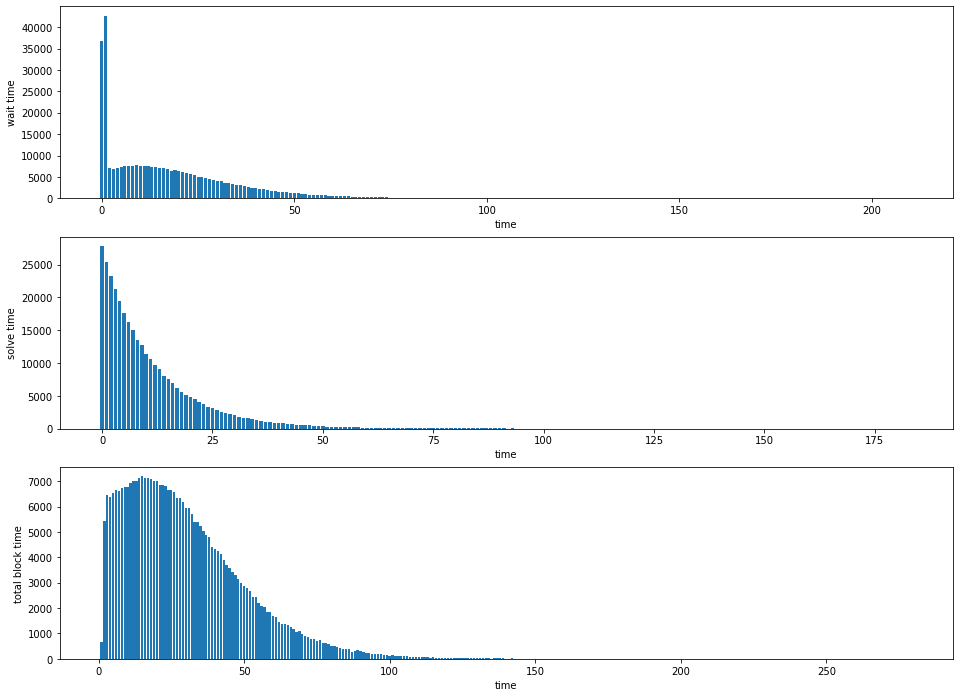

In [376]:
plotHist(hists)